In [7]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to the database
conn = sqlite3.connect("northwind.db")

In [2]:
# View available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
tables

,name
0,Categories
1,sqlite_sequence
2,CustomerCustomerDemo
3,CustomerDemographics
4,Customers
5,Employees
6,EmployeeTerritories
7,Order Details
8,Orders
9,Products


In [3]:
# Total Sales per Category
query = """
SELECT c.CategoryName, SUM(od.Quantity * od.UnitPrice) AS TotalSales
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
JOIN Categories c ON p.CategoryID = c.CategoryID
GROUP BY c.CategoryName
ORDER BY TotalSales DESC;
"""
pd.read_sql_query(query, conn)

,CategoryName,TotalSales
0,Beverages,92181842.95
1,Confections,66347544.94
2,Meat/Poultry,64896314.41
3,Dairy Products,58034940.00
4,Condiments,55802774.45
5,Seafood,49931965.52
6,Produce,32706403.90
7,Grains/Cereals,28573512.55


In [4]:
# Top 5 Most Sold Products
query = """
SELECT p.ProductName, SUM(od.Quantity) AS TotalUnitsSold
FROM [Order Details] od
JOIN Products p ON od.ProductID = p.ProductID
GROUP BY p.ProductName
ORDER BY TotalUnitsSold DESC
LIMIT 5;
"""
pd.read_sql_query(query, conn)


,ProductName,TotalUnitsSold
0,Louisiana Hot Spiced Okra,206213
1,Sir Rodney's Marmalade,205637
2,Teatime Chocolate Biscuits,205487
3,Sirop d'érable,205005
4,Gumbär Gummibärchen,204761


In [5]:
# Customers with Most Orders
query = """
SELECT c.CompanyName, COUNT(o.OrderID) AS OrderCount
FROM Customers c
JOIN Orders o ON c.CustomerID = o.CustomerID
GROUP BY c.CompanyName
ORDER BY OrderCount DESC
LIMIT 5;
"""
pd.read_sql_query(query, conn)

,CompanyName,OrderCount
0,IT,335
1,B's Beverages,210
2,Ricardo Adocicados,203
3,LILA-Supermercado,203
4,Gourmet Lanchonetes,202


In [19]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
# Monthly Sales Trend (Revenue by Month)
query = """
SELECT strftime('%Y-%m', o.OrderDate) AS OrderMonth,
       ROUND(SUM(od.UnitPrice * od.Quantity), 2) AS TotalRevenue
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
GROUP BY OrderMonth
ORDER BY OrderMonth;
"""

monthly_sales = pd.read_sql_query(query, conn)
monthly_sales

,OrderMonth,TotalRevenue
0,2012-07,2066219.40
1,2012-08,3556875.79
2,2012-09,3440144.98
3,2012-10,3201529.96
4,2012-11,2980494.74
...,...,...
131,2023-06,3071787.73
132,2023-07,3350337.36
133,2023-08,3293158.67
134,2023-09,3544698.51


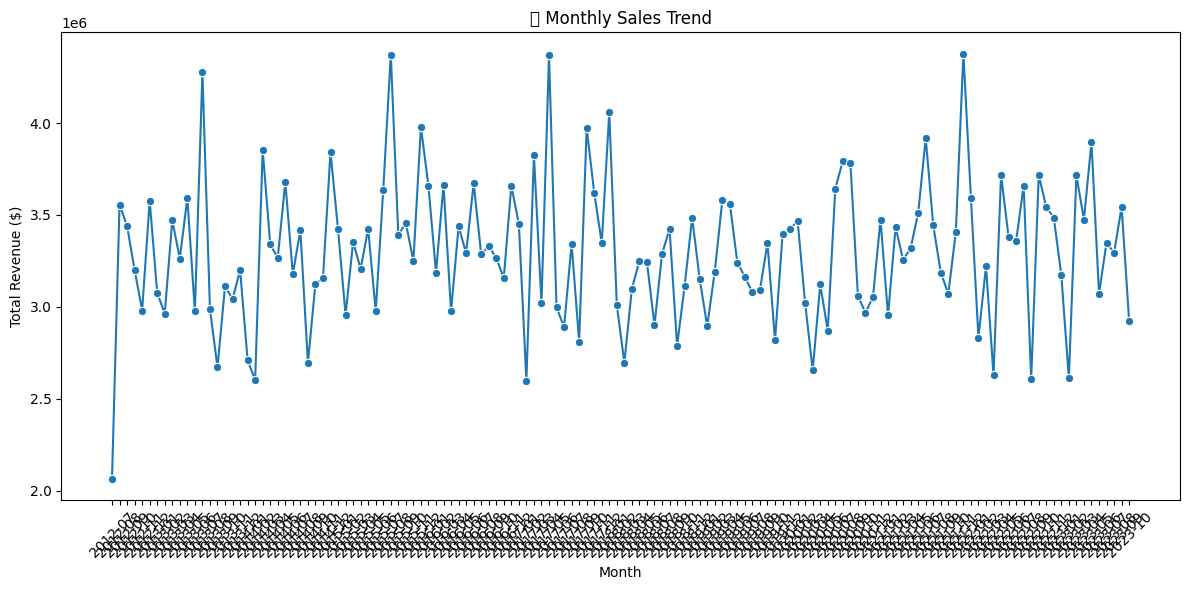

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="OrderMonth", y="TotalRevenue", marker='o')
plt.xticks(rotation=45)
plt.title("📈 Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Revenue ($)")
plt.tight_layout()
plt.show()

In [22]:
# Top Employees by Revenue Generated
query = """
SELECT e.FirstName || ' ' || e.LastName AS EmployeeName,
       ROUND(SUM(od.UnitPrice * od.Quantity), 2) AS TotalSales
FROM [Order Details] od
JOIN Orders o ON od.OrderID = o.OrderID
JOIN Employees e ON o.EmployeeID = e.EmployeeID
GROUP BY EmployeeName
ORDER BY TotalSales DESC;
"""
employee_sales = pd.read_sql_query(query, conn)
employee_sales

,EmployeeName,TotalSales
0,Margaret Peacock,51505691.80
1,Steven Buchanan,51393234.57
2,Janet Leverling,50455812.22
3,Nancy Davolio,49669459.34
4,Robert King,49668627.06
5,Laura Callahan,49287575.56
6,Michael Suyama,49144251.53
7,Anne Dodsworth,49025334.37
8,Andrew Fuller,48325312.27


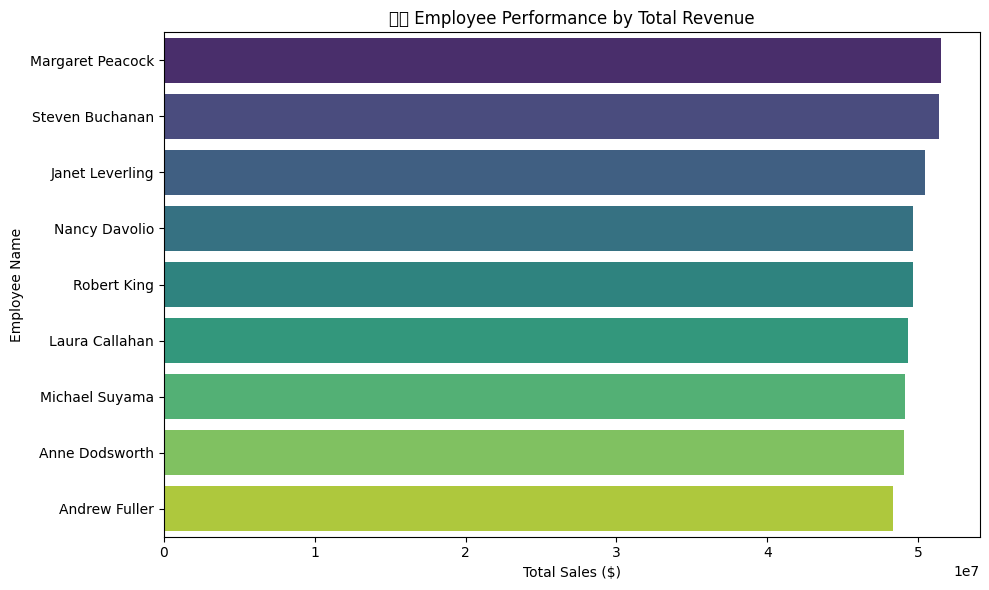

In [23]:
plt.figure(figsize=(10, 6))
sns.barplot(data=employee_sales, x="TotalSales", y="EmployeeName", palette="viridis")
plt.title("👨‍💼 Employee Performance by Total Revenue")
plt.xlabel("Total Sales ($)")
plt.ylabel("Employee Name")
plt.tight_layout()
plt.show()

In [12]:
# Average Delivery Time by Shipper
query = """
SELECT s.CompanyName AS Shipper,
       ROUND(AVG(julianday(o.ShippedDate) - julianday(o.OrderDate)), 2) AS AvgDeliveryDays
FROM Orders o
JOIN Shippers s ON o.ShipVia = s.ShipperID
WHERE o.ShippedDate IS NOT NULL AND o.OrderDate IS NOT NULL
GROUP BY Shipper
ORDER BY AvgDeliveryDays;
"""
delivery = pd.read_sql_query(query, conn)
delivery

,Shipper,AvgDeliveryDays
0,United Package,7.78
1,Federal Shipping,7.82
2,Speedy Express,7.92


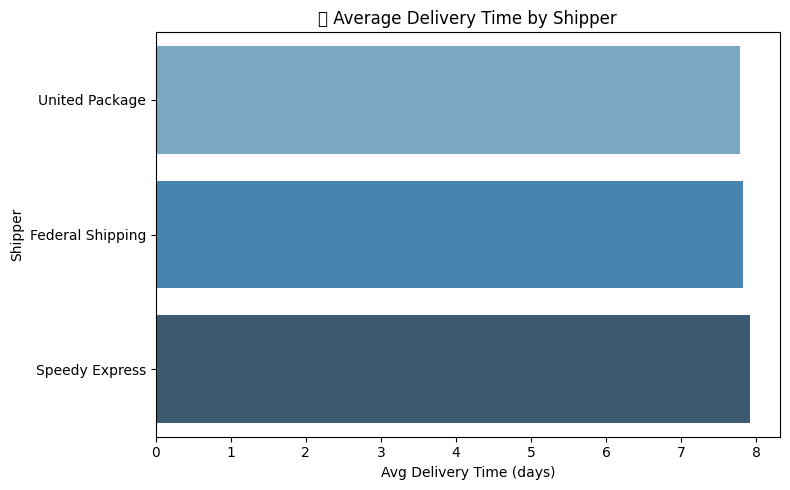

In [24]:
plt.figure(figsize=(8, 5))
sns.barplot(data=delivery, x="AvgDeliveryDays", y="Shipper", palette="Blues_d")
plt.title("🚚 Average Delivery Time by Shipper")
plt.xlabel("Avg Delivery Time (days)")
plt.ylabel("Shipper")
plt.tight_layout()
plt.show()

In [16]:
# Returning vs One-Time Customers
query = """
SELECT 
    CASE 
        WHEN OrderCount = 1 THEN 'One-Time Customer'
        ELSE 'Returning Customer'
    END AS CustomerType,
    COUNT(*) AS NumCustomers
FROM (
    SELECT CustomerID, COUNT(OrderID) AS OrderCount
    FROM Orders
    GROUP BY CustomerID
)
GROUP BY CustomerType;
"""
customer_types  = pd.read_sql_query(query, conn)
customer_types 

,CustomerType,NumCustomers
0,Returning Customer,93


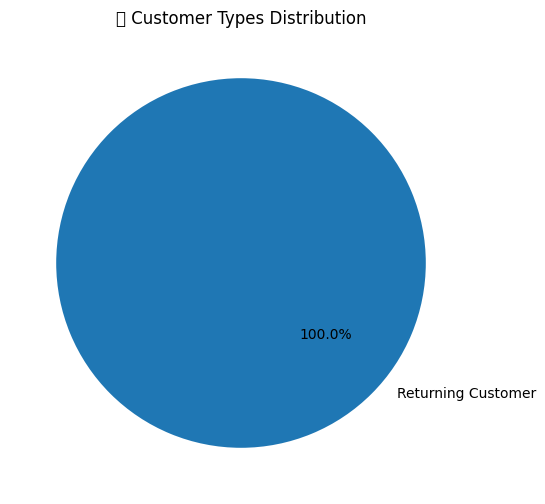

In [25]:
plt.figure(figsize=(6, 6))
plt.pie(customer_types["NumCustomers"],
        labels=customer_types["CustomerType"],
        autopct='%1.1f%%',
        startangle=140)
plt.title("🧾 Customer Types Distribution")
plt.show()